# Optimization

<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Setup</h1></u>
</div>

In the finite-dimensional unconstrained optimization problem, one is given a function $f : R^n \mapsto R$ and asked to find an $x^∗$ such that $f (x^∗) \geq f(x)$ for all $x$. We call $f$ the objective function and $x^∗$ , if it exists, the global maximum of $f$. We focus on maximization - to solve a minimization problem, simply maximize the negative of the objective.


We say that $x^∗ \in R^n$ is a ...

* strict global maximum of $f$ if $f(x^∗) > f (x)$ for all $x\neq x^∗$.
* local maximum of $f$ if $f(x^∗) \geq f(x)$ for all $x$ in some neighborhood of $x^∗$.
* strict local maximum of $f$ if $f(x^∗) > f(x)$ for all $x\neq x^∗$ in some neighborhood of $x^∗$.


Let $f: R^n \mapsto R$ be twice continously differentiable.

* **First Order Necessary Conditions:** If $x^*$ is a local maximum of $f$, then $f^{\prime}(x^*) = 0$. 
* **Second Order Necessary Condition:** If $x^∗$ is a local maximum of $f$, then $f^{\prime\prime}(x^*)$ is negative semidefinite. 

We say $x$ is a critical point of $f$ if it satisfies the first-order necessary condition.

* **Sufficient Condition:** If $f^\prime (x^∗) = 0$ and $f^{\prime\prime}(x^∗)$ is negative definite, then $x^∗$ is a strict local maximum of $f$.
* **Local-Global Theorem:** If $f$ is concave, and $x^∗$ is a local maximum of $f$, then $x^∗$ is a global maximum of $f$.

Unconstrained optimization problems are ubiquitous in economics:
* Government maximizes social welfare
* Competitive equilibrium maximizes total surplus
* Ordinary least squares estimator minimizes sum of squares
* Maximum likelihood estimator maximizes likelihood function

In [96]:
from functools import partial

from scipy import optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np

from optimization_plots import plot_golden_search_problem
from optimization_problems import _get_test_function_gradient
from optimization_problems import get_parameterization
from optimization_problems import get_test_function
from optimization_auxiliary import process_results
from optimization_algorithms import golden_search
from optimization_auxiliary import get_bounds
from optimization_plots import plot_contour
from optimization_plots import plot_surf

<div class="alert alert-block alert-info">
    <u><h2>Derivative-Free Methods</h2></u>
</div>

As was the case with univariate rootfinding, optimization algorithms exist that will place progressively smaller brackets around a local maximum of a univariate function. Such methods are relatively slow, but they do not require the evaluation of function derivatives and are guaranteed to find a local optimum to a prescribed tolerance in a known number of steps.

### Golden search 

In [97]:
??golden_search

Signature: golden_search(f, a, b, tol=1e-05)
Docstring: <no docstring>
Source:   
def golden_search(f, a, b, tol=1e-5):
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    x1 = a + alpha1 * (b - a)
    f1 = f(x1)
    x2 = a + alpha2 * (b - a)
    f2 = f(x2)
    d = alpha1 * alpha2 * (b - a)

    while d > tol:
        d = d * alpha2
        if f2 < f1:
            x2 = x1
            x1 = x1 - d
            f2 = f1
            f1 = f(x1)
        else:
            x1 = x2
            x2 = x2 + d
            f1 = f2
            f2 = f(x2)

        if f2 > f1:
            x = x2
        else:
            x = x1

    return x
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_algorithms.py
Type:      function


We want to compute the maximum of the following function on the interval $[0, 3]$.

\begin{align*}
f(x) = x \cos (x^2)
\end{align*}

In [98]:
def golden_search_problem(x):
    return x * np.cos(x ** 2)

We start with a visualization.

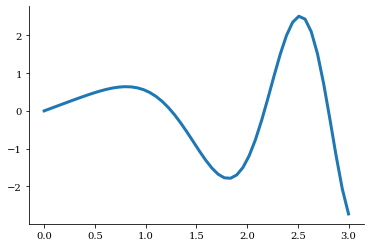

In [99]:
plot_golden_search_problem(golden_search_problem)

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>Whare is a potential problem?</li>
    </ul> 
</div>

In [100]:
x = golden_search(golden_search_problem, 0, 3)
print(f"Result from our algorithm is {x:5.3f}.")

Result from our algorithm is 0.808.


The golden search method is guaranteed to find the global maximum when the function is concave. However, as the present example makes clear, this guarantee does not hold when the optimand is not concave.

### Nelder-Mead

A derivative-free optimization method for multivariate functions is the Nelder-Mead algorithm. The algorithm begins by evaluating the objective function at $n + 1$ points. These $n + 1$ points form a so-called simplex in the n-dimensional decision space. This algorithm is most easily visualized when $x$ is two-dimensional, in which case a simplex is a triangle. 

<img src="material/fig-nelder-mead-iteration.png" width=500 height=500 />


The Nelder-Mead algorithm is simple but slow and unreliable.

</div><div class="alert alert-block alert-info">
    <u><h2>Derivative-based Methods</h2></u>
</div>

### Newton-Raphson Method

The Newton-Raphson method maximizes an objective $f$ using successive quadratic approximations. Given the $k$-th iterate $x_k$, the subsequent iterate $x_{k+1}$ is computed by maximizing the quadratic approximation to $f$ about $x_k$:

\begin{align*}
f(x) \approx f(x_k) + f^\prime(x_k) (x - x_k ) + \frac{1}{2} (x − x_k )^\prime f^{\prime\prime}(x_k) (x - x_k).
\end{align*}

Solving the first-order condition

\begin{align*}
    f^\prime(x_k ) + f^{\prime\prime}(x_k)(x - x_k ) = 0
\end{align*}

yields the iteration rule

\begin{align*}
x_{k+1} = x_k - [f ′′ (x_k)]^{-1} f^\prime(x_k)
\end{align*}

The Newton-Raphson method is identical to using Newton’s method to compute the root of the gradient of the objective. In theory, it will converge if the initial value is “close” to a critical point of $f$ at which the Hessian is non-singular. In practice, it will diverge if the initial value is “far” from a critical point or the Hessian becomes ill-conditioned. Moreover, it may converge to a critical point that is not a local maximum, so the second-order necessary condition should always be checked. Newton-Raphson can be robust to the starting value if $f$ is globally concave, but sensitive otherwise.

Newton-Raphson has two drawbacks:

* it requires computation of both the first and second derivatives. 
* it may not be possible to increase the objective in the direction of the Newton step ... this is guaranteed only if $f^{\prime\prime} (x_k)$ is negative definite. 


### Quasi-Newton Method

In analogy with the Newton-Raphson method, quasi-Newton methods update iterates in the direction of the vector

\begin{align*}
d_k = -A_k f^\prime(x_k)
\end{align*}

where $A_k$ is an approximation to the inverse Hessian of $f$ at the $k$th iterate $x_k$. The vector $d_k$ is called the Newton or quasi-Newton step. Just as with rootfinding problems, it is not always best to take a full Newton step at each iteration. Efficient quasi-Newton methods shorten or lengthen the Newton step to increase gains in the objective. This is accomplished by performing a line search in which the Newton step is re-scaled by a factor $s > 0$ that maximizes or nearly maximizes $f(x_k + s_k d_k )$. This is accomplished by performing a line search in which
the Newton step is re-scaled by a factor $s > 0$ that maximizes or nearly maximizes $f(x_k + s d_k)$.

Given the computed scaling factor $s_k$, one updates the iterate as follows:

\begin{align*}
x_{k+1} = x_k + s_k d_k.
\end{align*}

In practice, a thorough line search is not necessary. A number of different line search methods are used in practice.

Quasi-Newton algorithms differ in how the inverse Hessian approximation $A_k$ is constructed and updated. Efficient algorithms use negative definite inverse Hessian approximations, guaranteeing the objective can be increased in the direction of the Newton step. Efficient quasi-Newton algorithms also employ updating rules that do not require computing second derivatives.

* **Method of steepest ascent**

The simplest quasi-Newton method sets $A_k = −I$, where $I$ is the identity matrix, leading to a Newton step that is identical to the gradient of the objective: 

\begin{align*}
d_k = f^\prime(x_k).
\end{align*}

This is called the method of steepest ascent because the gradient, to a first order, promises the greatest increase in $f$.

<div class="alert alert-block alert-info">
    <u><h2>Test function</h2></u>
</div>


add ability for one-dinmension to show potential multiplicity if noise

- This notebook follows course notes `4_optimization-in-python.pdf`

- Minimize the function:
$$
f(x) = \sum_{i=1}^n a_i\cdot (x_i-1)^2+ b\cdot \left[ n-\sum_{i=1}^n\cos(2\pi(x_i-1))\right]
$$
- $b$  controls the amount of additional noise

User inputs:

- `dimension`: dimension $n$ above
- `conditioning_indicator`: defines the distribution of  $a_i$, $i=1,\ldots,n$
  - 0: well-conditioned (narrow distribution of $a_i$)
  - 1: ill-conditioned (wide distribution of $a_i$)
- `noise_indicator`: defines the amount of noise
  - 0: $b=0$ (no noise)
  - 1: $b=0.5$ (some noise)  

In [101]:
??get_parameterization

Signature: get_parameterization(dimension, add_noise, add_illco)
Docstring: <no docstring>
Source:   
def get_parameterization(dimension, add_noise, add_illco):
    # TODO: I think a scaling factor is missing.

    if add_noise:
        b = 1
    else:
        b = 0

    if add_illco:
        conditioning_factor = float(add_illco) * 20
        quadratic_coeff = np.array(np.exp(np.random.random(dimension) * conditioning_factor))
        quadratic_coeff = quadratic_coeff / np.max(quadratic_coeff)
        a = quadratic_coeff
    else:
        a = np.ones(dimension)

    return a, b
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


In [102]:
??get_test_function

Signature: get_test_function(x, a, b)
Docstring: <no docstring>
Source:   
def get_test_function(x, a, b):
    x, a = np.atleast_1d(x), np.atleast_1d(a)
    dimension = len(x)

    fval = 0
    for n in range(dimension):
        fval += a[n] * (x[n] - 1) ** 2

    fval += b * dimension

    for n in range(dimension):
        fval -= b * np.cos(2 * np.pi * (x[n] - 1))

    return fval
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


In [103]:
# Starting values
dimension = 2
x0 = np.array([4.5, -1.5])


add_noise, add_illco = True, False


def get_problem(dimension, add_noise, add_illco):
    a, b = get_parameterization(dimension, add_noise, add_illco)
    get_test_function_p = partial(get_test_function, a=a, b=b)
    get_test_function_gradient_p = partial(_get_test_function_gradient, a=a, b=b)
    return get_test_function_p, get_test_function_gradient_p


opt_test_function, opt_test_gradient = get_problem(dimension, add_noise, add_illco)
np.testing.assert_equal(opt_test_function([1, 1]), 0.0)

Let's see how the surface and contour plots look like under different scenarios.

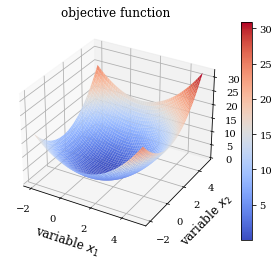

In [104]:
opt_test_function, _ = get_problem(dimension, add_noise=False, add_illco=False)
plot_surf(opt_test_function, dimension=2)

<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

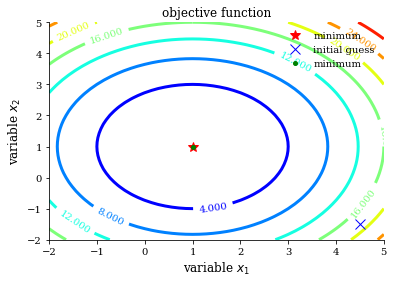

In [105]:
opt_test_function, _ = get_problem(dimension, add_noise=False, add_illco=False)
plot_contour(opt_test_function, [1, 1], "minimum")

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>How is the global maximum affected by the additon of noise and ill-conditioning?</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <u><h2>Benchmarking exercise</h2></u>
</div>


Let's get our problem setting and initialize a container for our results.

In [106]:
add_noise, add_illco, dimension = True, False, 10

In [107]:
x0 = np.zeros(dimension)
opt_test_function, opt_test_gradient = get_problem(dimension, add_noise, add_illco)
df = pd.DataFrame(columns=["Method", "Iteration", "Distance"], index=range(4))

Let's fix what will stay unchanged throughout.

In [108]:
call_optimizer = partial(
    opt.minimize,
    fun=opt_test_function,
    x0=x0,
    jac=opt_test_gradient,
    options={"disp": True, "return_all": True},
)

We prepared some functions to process results from the optimizer calls.

In [113]:
??process_results

Signature: process_results(df, method, res, pos)
Docstring: <no docstring>
Source:   
def process_results(df, method, res, pos):
    minimum = np.ones(res["x"].shape[0])
    df.loc[pos, :] = [
        method,
        res.nfev,
        np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum),
    ]
    return df
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_auxiliary.py
Type:      function


## Conjugate gradient

We can use the CG method with derivatives.

         Current function value: 10.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 4


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

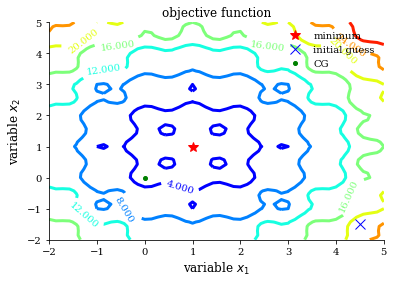

In [114]:
res = call_optimizer(method="CG")
df = process_results(df, "CG", res, 0)
plot_contour(opt_test_function, res.allvecs, "CG")

##  Newton-CG

Optimization terminated successfully.
         Current function value: 9.631286
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 7
         Hessian evaluations: 0


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

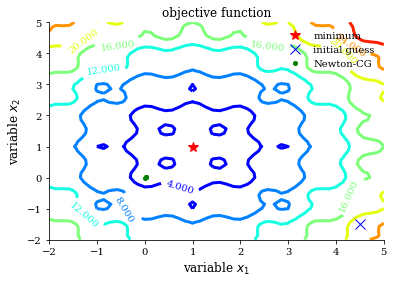

In [110]:
res = call_optimizer(method="Newton-CG")
df = process_results(df, "Newton-CG", res, 1)
plot_contour(opt_test_function, res.allvecs, "Newton-CG")

## Nelder Mead

Optimization terminated successfully.
         Current function value: 9.514566
         Iterations: 1101
         Function evaluations: 1534


/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

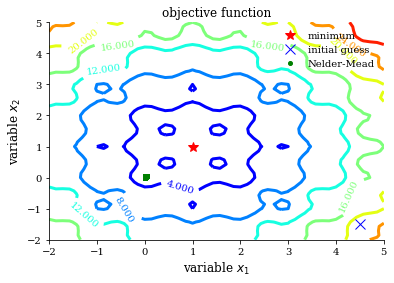

In [111]:
res = call_optimizer(method="Nelder-Mead")
df = process_results(df, "Nelder-Mead", res, 2)
plot_contour(opt_test_function, res.allvecs, "Nelder-Mead")

## Differential evolution

In [112]:
??get_bounds

Signature: get_bounds(dimension)
Docstring: <no docstring>
Source:   
def get_bounds(dimension):
    bounds = np.tile(np.nan, [dimension, 2])
    bounds[:, 0], bounds[:, 1] = -10, 10
    return bounds
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_auxiliary.py
Type:      function


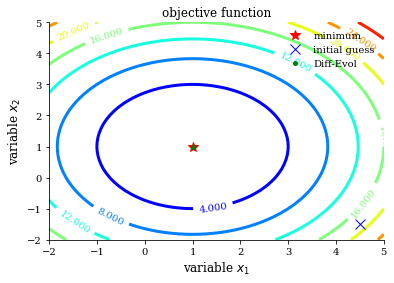

In [93]:
res = opt.differential_evolution(opt_test_function, get_bounds(dimension))
plot_contour(opt_test_function, res["x"], "Diff-Evol")
df = process_results(df, "Diff-Evol", res, 3)

## Summary

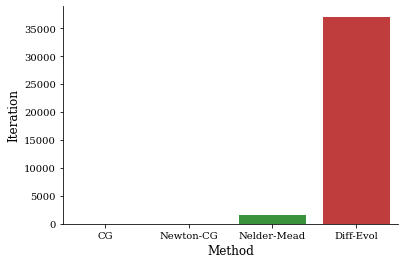

In [20]:
_ = sns.barplot(x="Method", y="Iteration", data=df)

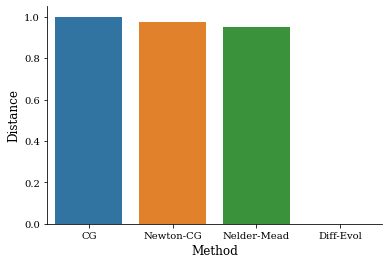

In [21]:
_ = sns.barplot(x="Method", y="Distance", data=df)

</div><div class="alert alert-block alert-info">
    <u><h2>Special cases</h2></u>
</div>


### Nonlinear least squares

We will estimate the following nonlinear consumption function using data from Greene's textbook. 

In [56]:
df = pd.read_pickle("material/data-consumption-function.pkl")
df.head()

realgdp  realcons
Year qtr                   
1950 1     1610.5    1058.9
     2     1658.8    1075.9
     3     1723.0    1131.0
     4     1753.9    1097.6
1951 1     1773.5    1122.8

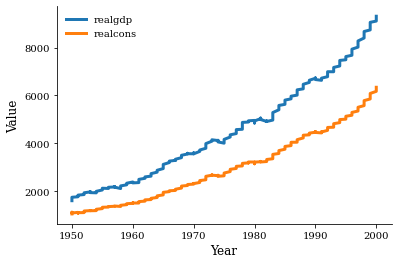

In [57]:
fig, ax = plt.subplots()
x = df.index.get_level_values("Year")

for name in ["realgdp", "realcons"]:
    y = df[name]
    ax.plot(x, y, label=name)

ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend()

In [65]:
consumption = df["realcons"].values
income = df["realgdp"].values


def ssr(x, consumption, income):
    alpha, beta, gamma = x
    residuals = consumption - alpha - beta * income ** gamma
    return residuals


ssr_partial = partial(ssr, consumption=consumption, income=income)
rslt = sp.optimize.least_squares(ssr_partial, [0, 0, 1])["x"]

In [68]:
def construct_predicted_values(income, alpha, beta, gamma):
    return alpha + beta * income ** gamma


income = df["realgdp"].values
df["realcons_pred"] = construct_predicted_values(income, *rslt)

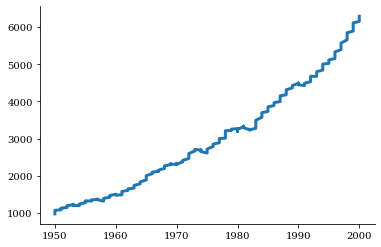

In [70]:
fig, ax = plt.subplots()
ax.plot(x, df["realcons_pred"], label=name)

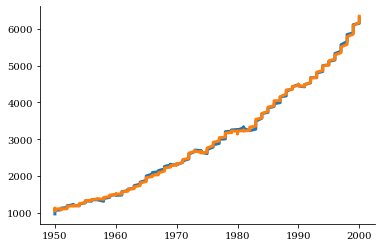

In [27]:
fig, ax = plt.subplots()
ax.plot(x, df["realcons_pred"], label=name)
ax.plot(x, consumption, label=name)

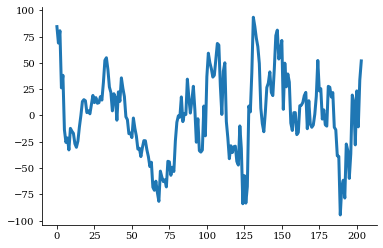

In [71]:
residuals = df["realcons"] - df["realcons_pred"]
fig, ax = plt.subplots()
ax.plot(residuals.values)

### Maximum likelihood estimation

In [41]:
df = pd.read_pickle("material/data-graduation-prediction.pkl")
df.head()

,GPA,TUCE,PSI,GRADE,INTERCEPT,GRADE
OBS,,,,,,
1,2.66,20,0,0,1,0
2,2.89,22,0,0,1,0
3,3.28,24,0,0,1,0
4,2.92,12,0,0,1,0
5,4.00,21,0,1,1,1


In [ ]:
def probit_model(beta, y, x):
    F = norm.cdf(x @ beta)
    fval = (y * np.log(F) + (1 - y) * np.log(1 - F)).sum()
    return -fval

In [48]:
x, y = df[["INTERCEPT", "GPA", "TUCE", "PSI"]], df["GRADE"]
rslt = opt.minimize(probit_model, [0.0] * 4, args=(y, x))

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li> Amend the code so that you can simply switch between estimating a Probit or Logit model.</li>
    </ul> 

### Resources

* https://kevintcarlberg.net/

* https://colab.research.google.com/drive/1BDMtNmc1b-S7WPE8BBozPOxU0_7sYXpQ#scrollTo=S6lOTjEh1Jyb

* https://kevintcarlberg.net/files/opt_class_icme/4_optimization-in-python.pdf

### Software 

* https://en.wikipedia.org/wiki/List_of_optimization_software

### Books

* https://www.amazon.de/-/en/Jorge-Nocedal/dp/0387303030/ref=sr_1_1?dchild=1&keywords=nocedal+wright&qid=1605168584&sr=8-1* 

* https://www.amazon.de/-/en/Stephen-Boyd/dp/0521833787/ref=sr_1_3?dchild=1&keywords=optimization&qid=1605168744&sr=8-3

* https://www.amazon.de/-/en/Mykel-J-Kochenderfer/dp/0262039427/ref=sr_1_1?dchild=1&keywords=optimization&qid=1605168758&sr=8-1